# Stormen voorspellen

## Daniëlle Weustenenk

### 23-01-2022

# Introductie
In dit onderzoek ga ik kijken of ik kan voorspellen wanneer er een storm komt in Nederland. Mijn onderzoeksvraag luidt: "Kan je voorspellen of er een storm komt?" Dit doe ik aan de hand van 2 websites van het KNMI. Ik heb een dataset gedownload die de dagwaarden van de weerstations De Bilt weergeeft van 1911 tot 2021 en heb een tabel gescrapet die de stormen van 1911 tot 2021 weergeeft.

# Bronnen
* KNMI. (1911–2021b, januari 1–december 31). Dagwaarden van weerstations [De Bilt]. Ministerie van Infrastructuur en Waterstaat. https://daggegevens.knmi.nl/
* KNMI. (1911–2021a). Zware stormen in Nederland sinds 1910 [Dataset]. Ministerie van Infrastructuur en Waterstaat. https://www.knmi.nl/nederland-nu/klimatologie/lijsten/zwarestormen

# Imports

In [664]:
from numpy import NaN
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# Datasets

Lees de daggegevens van knmi in

In [665]:
daggegevensDf = pd.read_csv("daggegevens.csv", skiprows=46, index_col=0) # Sla de eerste 46 regels over
print(daggegevensDf)

       YYYYMMDD  DDVEC  FHVEC     FG    FHX   FHXH    FHN   FHNH    FXX  \
# STN                                                                     
260    19110101    254     46     57     72      9     31     24          
260    19110102    281     21     31     46      1     10     21          
260    19110103     51     51     57     72     17     41      4          
260    19110104     50     51     51     82     15     36     21          
260    19110105     51     31     31     51     12     10     23          
...         ...    ...    ...    ...    ...    ...    ...    ...    ...   
260    20211227    141     33     33     40     11     30      1     80   
260    20211228    216     29     45     70     13     30      1    170   
260    20211229    231     30     37     50     18     20      9    100   
260    20211230    236     64     64     80     12     50      2    150   
260    20211231    227     55     55     70      7     40     17    140   

        FXXH  ...   VVNH

C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,13,15,16,17,18,19,20,21,22,23,24,27,29,30,31,32,33,34,36,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Scrape de zware stormen

In [666]:

url = "https://www.knmi.nl/nederland-nu/klimatologie/lijsten/zwarestormen" 
response = requests.get(url) 
html = BeautifulSoup(response.text, "html.parser") 
table = html.find_all('table')

stormenDf = pd.read_html(str(table)) # Lees de tabel in
stormenDf = pd.DataFrame(stormenDf[0])
stormenList =  []

for index, row in stormenDf.iterrows():
    stormenList.append([row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[9]]) # Voeg de tabel toe aan de stormenList

stormenDf = pd.DataFrame(stormenList) # Zet de stormenList om naar een DataFrame
stormenDf.to_csv("stormen.csv", index=False)

In [667]:
# Maanden omzetten naar cijfers
for col in stormenDf:
    stormenDf[1] = stormenDf[1].str.replace(' jan', '01')
    stormenDf[1] = stormenDf[1].str.replace(' feb', '02')
    stormenDf[1] = stormenDf[1].str.replace(' mrt', '03')
    stormenDf[1] = stormenDf[1].str.replace(' apr', '04')
    stormenDf[1] = stormenDf[1].str.replace(' mei', '05')
    stormenDf[1] = stormenDf[1].str.replace(' jun', '06')
    stormenDf[1] = stormenDf[1].str.replace(' jul', '07')
    stormenDf[1] = stormenDf[1].str.replace(' aug', '08')
    stormenDf[1] = stormenDf[1].str.replace(' sep', '09')
    stormenDf[1] = stormenDf[1].str.replace(' okt', '10')
    stormenDf[1] = stormenDf[1].str.replace(' nov', '11')
    stormenDf[1] = stormenDf[1].str.replace(' dec', '12')

# Nul toevoegen aan ééncijferige data (bijvoorbeeld 1 oktober, 110 --> 0101)
for index, row in stormenDf.iterrows():
    if len(row[1]) < 4:
        stormenDf.iat[index, 1] = '0' + stormenDf.iloc[index][1]

print(stormenDf)
stormenDf.to_csv('stormen2.csv', index=False)

       0           1   2   3    4     5      6                 7      8
0   1911  3009/  110  11  30  108  38.0  137.0  Hoek van Holland    NaN
1   1912        2708  10  27   97  41.0  148.0  Hoek van Holland    NaN
2   1913     26/2712  10  28  101   NaN    NaN        Vlissingen    NaN
3   1914        1208  10  26   94   NaN    NaN        Den Helder    NaN
4   1914        1111  10  26   94   NaN    NaN        Vlissingen    NaN
..   ...         ...  ..  ..  ...   ...    ...               ...    ...
61  2016        2011  10  26   94  37.0  133.0          IJmuiden    NaN
62  2017        1309  10  26   94  35.0  126.0          Vlieland    NaN
63  2018        0301  10  26   94  34.0  122.0          Vlieland    NaN
64  2018        1801  11  30  108  40.0  144.0  Hoek van Holland    NaN
65  2020        0902  10  25   90  36.0  130.0          Vlieland  Ciara

[66 rows x 9 columns]


Sommige stormen duren twee dagen. Ik duplicate stormen2.csv en verander de naam in stormen3.csv. Ik bewerk het csv bestand handmatig: stond er bijvoorbeeld eerst als datum "3009/   110", dan worden dat nu twee rijen met datum 30-09 en 01-10.

Ik hernoem de kolommen:

In [668]:
stormenDf3 = pd.read_csv ('stormen3.csv', dtype=str)

stormenDf3 = stormenDf3.rename(columns={'0': 'YYYYMMDD',
                                        '1': 'Datum',
                                        '2': 'Hoogste windsnelheid Bft',
                                        '3': 'Hoogste uur m/s',
                                        '4': 'Hoogste uur km/h',
                                        '5': 'Zwaarste windstoot m/s',
                                        '6': 'Zwaarste windstoot km/h',
                                        '7': 'Plaats',
                                        '8': 'Naam',})

De kolom jaartal en datum worden samengevoegd zodat hij overeenkomt met dagwaarden dataframe: YYYYMMDD

In [669]:
stormenDf3['Date'] = stormenDf3['Datum'].str[:2]
stormenDf3['Month'] = stormenDf3['Datum'].str[2:]
stormenDf3['YYYYMMDD'] = stormenDf3['YYYYMMDD'] + stormenDf3['Month'] + stormenDf3['Date']

del stormenDf3['Datum']
del stormenDf3['Month']
del stormenDf3['Date']

print(stormenDf3)

    YYYYMMDD Hoogste windsnelheid Bft Hoogste uur m/s Hoogste uur km/h  \
0   19110930                       11              30              108   
1   19111001                       11              30              108   
2   19120827                       10              27               97   
3   19131226                       10              28              101   
4   19131227                       10              28              101   
..       ...                      ...             ...              ...   
73  20161120                       10              26               94   
74  20170913                       10              26               94   
75  20180103                       10              26               94   
76  20180118                       11              30              108   
77  20200209                       10              25               90   

   Zwaarste windstoot m/s Zwaarste windstoot km/h            Plaats   Naam  
0                    38.0         

Ik maak een nieuwe kolom die bijhoudt of het heeft gestormd die dag.

In [670]:
stormTrueOrFalse = []
for i in range(len(stormenDf3)):
    stormTrueOrFalse.append(1) # Voeg telkens een 1 toe bij de stormen

stormenDf3.insert(1, 'Storm', stormTrueOrFalse)
stormenDf3['Storm'] = stormenDf3['Storm'].astype(int) # Sla de value op als boolean

Datasets samenvoegen

In [671]:
daggegevensDf['YYYYMMDD'] = daggegevensDf['YYYYMMDD'].astype(str)

df = stormenDf3.merge(daggegevensDf, how='right', left_on='YYYYMMDD', right_on='YYYYMMDD')
df['Storm'] = df['Storm'].fillna(0).astype(int) # Verander NaN in False

df.columns = df.columns.str.replace(' ', '') # Verwijder overige spaties in kolomnamen
df = df.replace(' ', '', regex=True) # Verwijder alle spaties

df.to_csv('daggegevens_en_stormen.csv', index=False)
df.info()
df.head(30) # Laat de dataset zien

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40543 entries, 0 to 40542
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   YYYYMMDD                40543 non-null  object
 1   Storm                   40543 non-null  int32 
 2   HoogstewindsnelheidBft  78 non-null     object
 3   Hoogsteuurm/s           78 non-null     object
 4   Hoogsteuurkm/h          78 non-null     object
 5   Zwaarstewindstootm/s    63 non-null     object
 6   Zwaarstewindstootkm/h   63 non-null     object
 7   Plaats                  78 non-null     object
 8   Naam                    1 non-null      object
 9   DDVEC                   40543 non-null  object
 10  FHVEC                   40543 non-null  object
 11  FG                      40543 non-null  object
 12  FHX                     40543 non-null  object
 13  FHXH                    40543 non-null  object
 14  FHN                     40543 non-null  object
 15  FH

,YYYYMMDD,Storm,HoogstewindsnelheidBft,Hoogsteuurm/s,Hoogsteuurkm/h,Zwaarstewindstootm/s,Zwaarstewindstootkm/h,Plaats,Naam,DDVEC,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,19110101,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254,...,,,,,87,,,,,
1,19110102,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,281,...,,,,,95,,,,,
2,19110103,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51,...,,,,,89,,,,,
3,19110104,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,...,,,,,86,,,,,
4,19110105,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51,...,,,,,90,,,,,
5,19110106,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,157,...,,,,,90,,,,,
6,19110107,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190,...,,,,,95,,,,,
7,19110108,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185,...,,,,,98,,,,,
8,19110109,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216,...,,,,,99,,,,,
9,19110110,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,278,...,,,,,88,,,,,


Om ook te kunnen kijken naar de datum maak ik een nieuwe kolom aan die de datum converteert naar een getal. Het programma kan geen datums lezen maar zo weet hij dan toch wanneer het gebeurt is.

In [672]:
df['YYYYMMDD'] = df['YYYYMMDD'].astype('datetime64[ns]') # Kolom YYYYMMDD omzetten van object naar TimeStamp

# Converteer de datum naar een nummer
fromDate = min(df['YYYYMMDD'])
df['Timedelta'] = (df['YYYYMMDD'] - fromDate).dt.days.astype(int)

df = df[ ['Timedelta'] + [ col for col in df.columns if col != 'Timedelta' ] ] # Verplaats de Timedelta kolom naar index 0
df = df[ ['Storm'] + [ col for col in df.columns if col != 'Storm' ] ] # Verplaats de YYYYMMDD kolom naar index 0

df.head(5)

,Storm,Timedelta,YYYYMMDD,HoogstewindsnelheidBft,Hoogsteuurm/s,Hoogsteuurkm/h,Zwaarstewindstootm/s,Zwaarstewindstootkm/h,Plaats,Naam,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,0,0,1911-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,87,,,,,
1,0,1,1911-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,95,,,,,
2,0,2,1911-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,89,,,,,
3,0,3,1911-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,86,,,,,
4,0,4,1911-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,90,,,,,


De eerste datum is nu dus nummer 0, de tweede datum nummer 1, etc.

# Data cleaning

*Het KNMI gaat uit van storm of windkracht 9 als een uurgemiddelde windsnelheid tussen 75 en 88 kilometer per uur (20,8 - 24,4 meter per seconde) gemeten wordt. Volgens de schaal van Beaufort is er sprake van storm als er een 10 minuut gemiddelde windsnelheid tussen 75 en 88 km/u gemeten wordt.*

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- KNMI. (z.d.). Storm. Ministerie van Infrastructuur en Waterstaat. Geraadpleegd op 11 januari 2022, van https://www.knmi.nl/kennis-en-datacentrum/uitleg/storm 


Ik ga nu kijken welke variabelen waardevol zijn voor het onderzoek.

---

* *YYYYMMDD*: Jaartal/Maand/Dag
* *Storm*: Heeft het gestormd? True/False, de dependent waarde
* *Hoogste windsnelheid Bft*: bevat vrijwel alleen maar NaN en is niet waardevol voor het onderzoek
* *Hoogste uur m/s*: bevat vrijwel alleen maar NaN en is niet waardevol voor het onderzoek
* *Hoogste uur km/h*: bevat vrijwel alleen maar NaN en is niet waardevol voor het onderzoek
* *Zwaarste windstoot m/s*: bevat vrijwel alleen maar NaN en is niet waardevol voor het onderzoek
* *Zwaarste windstoot km/h*: bevat vrijwel alleen maar NaN en is niet waardevol voor het onderzoek
* *Plaats*: bevat vrijwel alleen maar NaN en is niet waardevol voor het onderzoek
* *Naam*: bevat vrijwel alleen maar NaN en is niet waardevol voor het onderzoek
* *(DDVEC) Vectorgemiddelde windrichting in graden (360=noord, 90=oost, 180=zuid, 270=west, 0=windstil/variabel*: irrelevant
* *(FHVEC) Vectorgemiddelde windsnelheid (in 0.1 m/s)*: relevant
* *(FG) Etmaalgemiddelde windsnelheid (in 0.1 m/s)*: relevant
* *(FHX) Hoogste uurgemiddelde windsnelheid (in 0.1 m/s)*: relevant
* *(FHXH) Uurvak waarin FHX is gemeten*: irrelevant
* *(FHN) Laagste uurgemiddelde windsnelheid (in 0.1 m/s)*: irrelevant
* *(FHNH) Uurvak waarin FHN is gemeten*: irrelevant
* *(FXX) Hoogste windstoot (in 0.1 m/s)*: relevant, maar heeft veel NaN dus niet waardevol voor het onderzoek
* *(FXXH) Uurvak waarin FXX is gemeten*: irrelevant
* *(TG) Etmaalgemiddelde temperatuur (in 0.1 graden Celsius)*: irrelevant
* *(TN) Minimum temperatuur (in 0.1 graden Celsius)*: irrelevant
* *(TNH) Uurvak waarin TN is gemeten*: irrelevant
* *(TX) Maximum temperatuur (in 0.1 graden Celsius)*: irrelevant
* *(TXH) Uurvak waarin TX is gemeten*: irrelevant
* *(T10N) Minimum temperatuur op 10 cm hoogte (in 0.1 graden Celsius)*: irrelevant
* *(T10NH) 6-uurs tijdvak waarin T10N is gemeten 6=0-6 UT, 12=6-12 UT, 18=12-18 UT, 24=18-24 UT*: irrelevant
* *(SQ) Zonneschijnduur (in 0.1 uur) berekend uit de globale straling (-1 voor <0.05 uur)*: irrelevant
* *(SP) Percentage van de langst mogelijke zonneschijnduur*: irrelevant
* *(Q) Globale straling (in J/cm2)*: irrelevant
* *(DR) Duur van de neerslag (in 0.1 uur)*: irrelevant
* *(RH) Etmaalsom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm)*: irrelevant
* *(RHX) Hoogste uursom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm)*: irrelevant
* *(RHXH) Uurvak waarin RHX is gemeten*: irrelevant
* *(PG) Etmaalgemiddelde luchtdruk herleid tot zeeniveau (in 0.1 hPa) berekend uit 24 uurwaarden*: irrelevant
* *(PX) Hoogste uurwaarde van de luchtdruk herleid tot zeeniveau (in 0.1 hPa)*: irrelevant
* *(PXH) Uurvak waarin PX is gemeten / Hourly division in which PX was measured*: irrelevant
* *(PN) Laagste uurwaarde van de luchtdruk herleid tot zeeniveau (in 0.1 hPa)*: irrelevant
* *(PNH) Uurvak waarin PN is gemeten / Hourly division in which PN was measured*:irrelevant
* *(VVN) Minimum opgetreden zicht; 0: <100 m, 1:100-200 m, 2:200-300 m,..., 49:4900-5000 m, 50:5-6 km, 56:6-7 km, 57:7-8 km,..., 79:29-30 km, 80:30-35 km, 81:35-40 km,..., 89: >70 km*: irrelevant
* *(VVNH) Uurvak waarin VVN is gemeten / Hourly division in which VVN was measured*: irrelevant
* *(VVX) Maximum opgetreden zicht; 0: <100 m, 1:100-200 m, 2:200-300 m,..., 49:4900-5000 m, 50:5-6 km, 56:6-7 km, 57:7-8 km,..., 79:29-30 km, 80:30-35 km, 81:35-40 km,..., 89: >70 km)*: irrelevant
* *(VVXH) Uurvak waarin VVX is gemeten*: irrelevant
* *(NG) Etmaalgemiddelde bewolking (bedekkingsgraad van de bovenlucht in achtsten, 9=bovenlucht onzichtbaar)*: irrelevant
* *(UG) Etmaalgemiddelde relatieve vochtigheid (in procenten)*: irrelevant
* *(UX) Maximale relatieve vochtigheid (in procenten)*: irrelevant
* *(UXH) Uurvak waarin UX is gemeten*: irrelevant
* *(UN) Minimale relatieve vochtigheid (in procenten)*: irrelevant
* *(UNH) Uurvak waarin UN is gemeten*: irrelevant
* *(EV24) Referentiegewasverdamping (Makkink) (in 0.1 mm)*: irrelevant

Onderstaande waarden zijn relevant voor ons onderzoek:
* We gaan werken met: *YYYYMMDD*, *Storm*, *FHVEC* (Vectorgemiddelde windsnelheid (in 0.1 m/s)), *FG* (Etmaalgemiddelde windsnelheid (in 0.1 m/s)), *FHX* (Hoogste uurgemiddelde windsnelheid (in 0.1 m/s))

In [673]:
df = df[['Timedelta','Storm', 'FHVEC', 'FG', 'FHX']]

df['FHVEC'] = pd.to_numeric(df['FHVEC'])
df['FG'] = pd.to_numeric(df['FG'])
df['FHX'] = pd.to_numeric(df['FHX'])

df.convert_dtypes().dtypes    

df.head(30)
df.info()
df.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40543 entries, 0 to 40542
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timedelta  40543 non-null  int32  
 1   Storm      40543 non-null  int32  
 2   FHVEC      40513 non-null  float64
 3   FG         40513 non-null  float64
 4   FHX        40513 non-null  float64
dtypes: float64(3), int32(2)
memory usage: 1.5 MB


Timedelta      int32
Storm          int32
FHVEC        float64
FG           float64
FHX          float64
dtype: object

In [674]:
df = df.dropna() # Verwijder rijen met lege cellen
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40513 entries, 0 to 40542
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timedelta  40513 non-null  int32  
 1   Storm      40513 non-null  int32  
 2   FHVEC      40513 non-null  float64
 3   FG         40513 non-null  float64
 4   FHX        40513 non-null  float64
dtypes: float64(3), int32(2)
memory usage: 1.5 MB


In [675]:
# YYYYMMDD omdraaien met Storm
titles = list(df.columns)
titles[0], titles[1] = titles[1], titles[0]
df = df[titles]

# Float naar int omzetten
df['FHVEC'] = df['FHVEC'] .astype(int)
df['FG'] = df['FG'] .astype(int)
df['FHX'] = df['FHX'] .astype(int)

df.head(30)

,Storm,Timedelta,FHVEC,FG,FHX
0,0,0,46,57,72
1,0,1,21,31,46
2,0,2,51,57,72
3,0,3,51,51,82
4,0,4,31,31,51
5,0,5,41,46,98
6,0,6,51,57,77
7,0,7,72,72,87
8,0,8,41,57,77
9,0,9,41,51,67


Het aantal stormen dat er geweest zijn is 78.

In [676]:
df['Storm'].value_counts()

0    40435
1       78
Name: Storm, dtype: int64

Er is dus veel vaker geen storm dan wél storm. In 40435 / (40435 + 78) * 100 = 99,8% van de keren is er géén storm en in slechts 0.2% van de tijd is er wél een storm.

# Het model bouwen

Ik ga werken met *Random Forest* omdat ik dan met verschillende variabelen kan gaan voorspellen of het gaat stormen en ik er niet slechts één hoef te kiezen zoals met knn bijvoorbeeld. 

We pakken de X en y en splitten de data.

In [677]:
X = df.loc[:,'Timedelta':'FHX'] 
y = df['Storm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Algoritme trainen

In [678]:
rf = RandomForestClassifier(random_state=1, n_estimators=100) #RF is a random algorithm, so to get the same results we need to use random_state
rf = rf.fit(X_train, y_train)

Reken de accuraatheid uit

In [679]:
rf.score(X_test,y_test)

0.9981076188909002

# Evalueren van het model

In [680]:
rf.classes_

array([0, 1])

## Confusion Matrix

In [681]:
y_pred = rf.predict(X_test) #the predicted values
cm = confusion_matrix(y_test, y_pred) #creates a "confusion matrix"
cm = pd.DataFrame(cm, index=['Geen storm (actual) 1', 'Wél storm (actual) 0'], columns = ['1 Geen storm (pred)', '0 Wél storm (pred)']) #label and make df
cm

,1 Geen storm (pred),0 Wél storm (pred)
Geen storm (actual) 1,12126,3
Wél storm (actual) 0,20,5


| TP | FP |
|---|---|
| FN | TN |

**True Positive**: 12126x verwachten we **geen** storm --> en er is ook **geen** storm <br/>
**True Negative**: 5x verwachten we **wel** storm --> en er is ook **wel** storm<br/>
**False Positive**: 3x verwachten we **wel** storm --> maar er is **geen** storm <br/>
**False Negative**: 20x verwachten we **geen** storm --> Maar er is **wel** storm <br/>

We hadden eigenlijk liever gehad dat False Negative wat lager is. We willen namelijk liever denken dat er een storm komt en dat die er dan uiteindelijk niet komt, dan dat we denken dat er geen storm komt en er wel een komt: we hebben ons dan minder goed kunnen voorbereiden.

In [682]:
print("Accuracy =", (12126 + 5) / (12123 + 5 + 3 + 20))
print("Misclassification =", (3 + 20) / (12123 + 5 + 3 + 20))
print("Precision =", (12126 / (12126 + 3)))
print("Recall (TP) =", 12126 / (12126 + 20))
print("Specificity (TN) =", 5 / (5 + 3), "*")


Accuracy = 0.9983540449345732
Misclassification = 0.001892848325240721
Precision = 0.9997526589166461
Recall (TP) = 0.9983533673637411
Specificity (TN) = 0.625 *


*Berekend volgens Ragan, A. (2018, 12 oktober). Taking the Confusion Out of Confusion Matrices. Towards Data Science. Geraadpleegd op 23 januari 2022, van https://towardsdatascience.com/taking-the-confusion-out-of-confusion-matrices-c1ce054b3d3e

Uit de confusion matrix kunnen we dus halen dat stormen niet heel goed worden gevonden: slechts 62,5% van de keren

Met *classification_report* halen we nog een sde precision en recall automatisch op

In [683]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12129
           1       0.62      0.20      0.30        25

    accuracy                           1.00     12154
   macro avg       0.81      0.60      0.65     12154
weighted avg       1.00      1.00      1.00     12154



De *precision* is niet zo goed: in 38% van de gevallen wanneer er een storm verwacht wordt is er geen storm.

De *recall* is zeer laag. We missen 80% van de stormen.

Voor dit onderzoek is het belangrijk dat vooral de recall omhoog gaat. Voor het voorspellen van stormen is het uiteraard belangrijker om een storm te zien aankomen die er uit eindelijk niet is, dan dat er een onverwachte storm komt.

### Andere parameters

In [684]:
rf_new  = RandomForestClassifier(n_estimators = 10, max_features = 'auto', random_state=1) #RF is a random algorithm, so to get the same results we need to use random_state
rf_new = rf_new.fit(X_train, y_train)
y_pred_new = rf_new.predict(X_test)
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12129
           1       0.50      0.08      0.14        25

    accuracy                           1.00     12154
   macro avg       0.75      0.54      0.57     12154
weighted avg       1.00      1.00      1.00     12154



Als we de max_features op *auto* verslechterd *recall* heel erg, we missen nu 92% van de stormen. 

De *precision* verslechterd ook: in 50% van de gevallen wanneer er een storm verwacht wordt is er geen storm.

### Nog andere parameters

In [685]:
rf_new  = RandomForestClassifier(n_estimators = 50, max_features = 'auto', random_state=1) #RF is a random algorithm, so to get the same results we need to use random_state
rf_new = rf_new.fit(X_train, y_train)
y_pred_new = rf_new.predict(X_test)
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12129
           1       0.75      0.24      0.36        25

    accuracy                           1.00     12154
   macro avg       0.87      0.62      0.68     12154
weighted avg       1.00      1.00      1.00     12154



Als we vervolgens het aantal bomen (*n_estimators*) op 50 zetten verbeterd de *precision*: in 25% van de gevallen wanneer er een storm verwacht wordt is er geen storm.

De *recall* is dan 76%, een kleine verbetering, maar nog steeds slecht.

### Probabilities gebruiken

Recall is dus een van de belangrijkste punten in deze case. Ik wil liever dat recall wordt verbeterd, ook als dat ten koste gaat van precision.

In [686]:
y_pred_prob = rf.predict_proba(X_test) #Instead of classes, we now get the probabilities
y_pred_prob


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

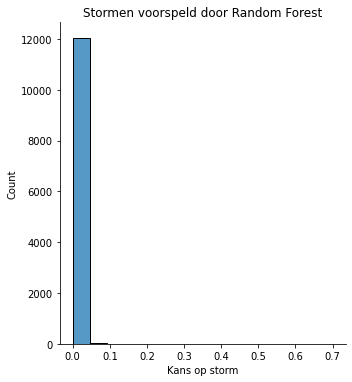

In [687]:
fraud_prob = y_pred_prob[:,1] 
sns.displot(fraud_prob)
plt.xlabel("Kans op storm")
plt.ylabel("Count")
plt.title("Stormen voorspeld door Random Forest")
plt.show()

Hier hebben we nie tzo veel aan omdat bijna alle kansen 0 zijn, dus het is niet zo informatief. Ik ga nu alleen diegene boven 0.01 laten zien:

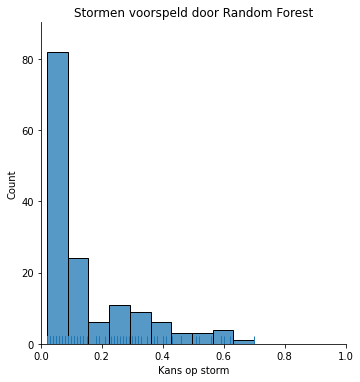

In [688]:
sns.displot(fraud_prob[fraud_prob > 0.01], bins=10, rug=True)
plt.xlim(0,1)
plt.xlabel("Kans op storm")
plt.ylabel("Count")
plt.title("Stormen voorspeld door Random Forest")
plt.show()

Uit deze grafiek kunnen we halen dat de meeste gevallen "een beetje" verdacht zijn, het is nooit zo dat hij het echt bijna zeker weet: Het is nooit hoger dan 0.7

Ik ga nu een andere cut-off gebruiken voor de stormen detectie en opnieuw de accuracy, precision en recall berekenen.

In [689]:
y_pred = (rf.predict_proba(X_test)[:,1] >= 0.1).astype(bool)
cm = confusion_matrix(y_test, y_pred) #creates a "confusion matrix"
cm = pd.DataFrame(cm, index=['Geen storm (actual) 1', 'Wél storm (actual) 0'], columns = ['1 Geen storm (pred)', '0 Wél storm (pred)']) #label and make df
cm

,1 Geen storm (pred),0 Wél storm (pred)
Geen storm (actual) 1,12090,39
Wél storm (actual) 0,6,19


In [690]:
print("Accuracy =", (12090 + 19) / (12090 + 19 + 39 + 6))

Accuracy = 0.9962975152213263


**True Positive**: 12090x verwachten we geen storm en dat is zo <br/>
**True Negative**: 19x verwachten we dat er geen storm is en er is ook geen storm <br/>
**False Positive**: 39x verwachten we dat er een storm is, maar dat is niet zo <br/>
**False Negative**: 6x verwachten we geen storm, maar die is er dan wel <br/>

Zoals verwacht is het nu vaker zo dat we denken dat er een storm komt, maar dat die er dan niet is.

In [691]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12129
           1       0.33      0.76      0.46        25

    accuracy                           1.00     12154
   macro avg       0.66      0.88      0.73     12154
weighted avg       1.00      1.00      1.00     12154



De *precision*: in 67% van de gevallen wanneer er een storm verwacht wordt is er geen storm.

De *recall* is nu een stuk beter, we missen 24% van de stormen.

Uiteindelijk is het model een stuk verbeterd maar niet perfect. Het blijft lastig om te voorspellen of er een storm aan komt.

# Bronnen

* KNMI. (1911–2021b, januari 1–december 31). Dagwaarden van weerstations [De Bilt]. Ministerie van Infrastructuur en Waterstaat. https://daggegevens.knmi.nl/
* KNMI. (1911–2021a). Zware stormen in Nederland sinds 1910 [Dataset]. Ministerie van Infrastructuur en Waterstaat. https://www.knmi.nl/nederland-nu/klimatologie/lijsten/zwarestormen
* KNMI. (z.d.). Storm. Ministerie van Infrastructuur en Waterstaat. Geraadpleegd op 11 januari 2022, van https://www.knmi.nl/kennis-en-datacentrum/uitleg/storm
* Ragan, A. (2018, 12 oktober). Taking the Confusion Out of Confusion Matrices. Towards Data Science. Geraadpleegd op 23 januari 2022, van https://towardsdatascience.com/taking-the-confusion-out-of-confusion-matrices-c1ce054b3d3e